In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataset seimbang sudah diatur sebelumnya
balanced_train_dir = '/content/drive/My Drive/Machine Learning/Soybean/balanced_train'
balanced_validation_dir = '/content/drive/My Drive/Machine Learning/Soybean/balanced_validation'

# Preprocessing dan Augmentasi
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(balanced_train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(balanced_validation_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

# Definisi parameter
num_labels = len(train_generator.class_indices)
img_shape = (150, 150, 3)

Found 1932 images belonging to 3 classes.
Found 505 images belonging to 3 classes.


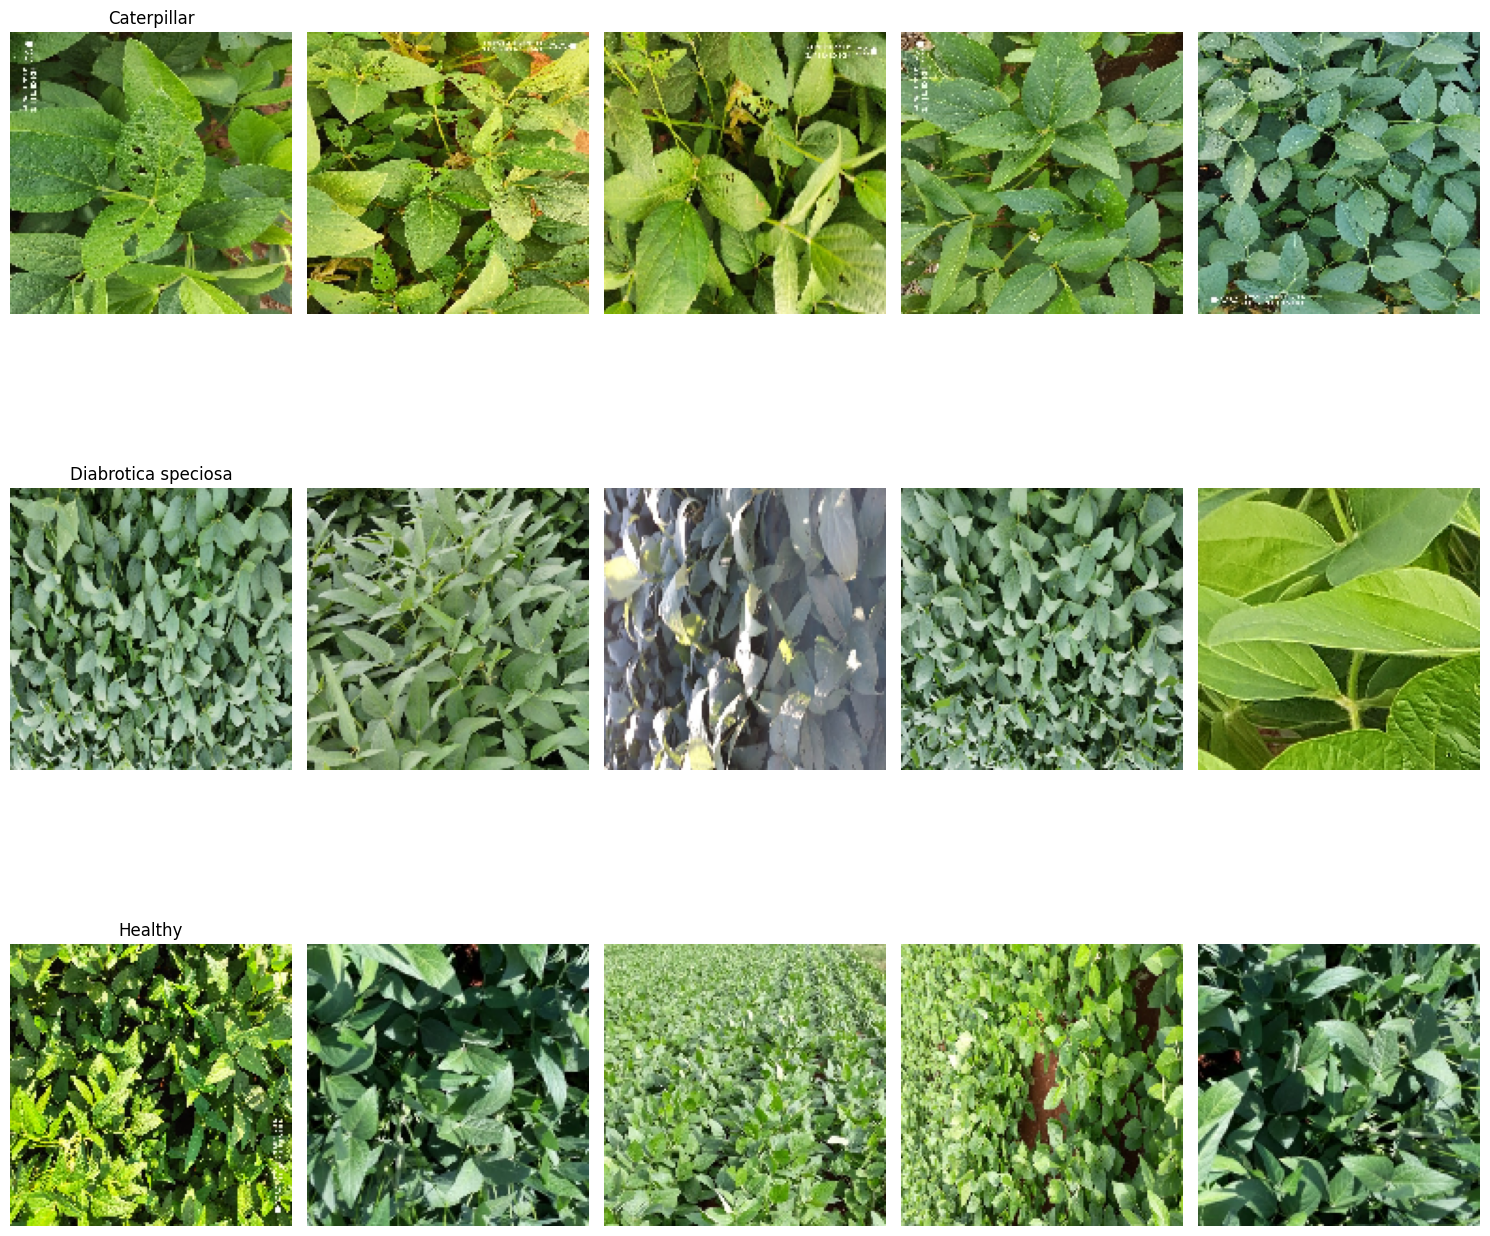

In [4]:
# Fungsi untuk menampilkan beberapa sampel gambar dari setiap kelas
def display_samples_from_all_classes(directory, class_names, num_samples=5):
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = os.listdir(class_path)[:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img_array)
            if j == 0:
                plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan 5 sampel gambar dari setiap kelas
class_names = list(train_generator.class_indices.keys())
display_samples_from_all_classes(balanced_train_dir, class_names)

In [5]:
# Fungsi untuk membuat model
def create_custom_model(base_model, model_name):
    model = Sequential([
        base_model(weights="imagenet", include_top=False, input_shape=img_shape),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(num_labels, activation='softmax')
    ])
    # Freeze backbone model
    model.layers[0].trainable = False
    model.summary()
    print(f"{model_name} model architecture created.\n")
    return model

In [6]:
# Callback untuk menghentikan pelatihan jika val_accuracy > 90%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            self.model.stop_training = True
            print("\nReached >90% validation accuracy, stopping training!")

early_stopping_callback = EarlyStoppingCallback()

In [7]:
# Daftar model yang akan dilatih
model_dict = {
    "ResNet152V2": ResNet152V2,
    "DenseNet121": DenseNet121,
    "MobileNetV2": MobileNetV2
}

In [8]:
# Variabel untuk menyimpan hasil terbaik
best_model_name = None
best_val_accuracy = 0
best_history = None

# Dictionary untuk menyimpan riwayat setiap model
history_dict = {}

In [9]:
# Melatih dan mengevaluasi setiap model secara terpisah
for model_name, base_model in model_dict.items():
    print(f"\nTraining {model_name}...")

    # Membuat model kustom
    model = create_custom_model(base_model, model_name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Melatih model
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping_callback]
    )

    # Simpan model ke Google Drive
    model_save_path = f'/content/drive/My Drive/Machine Learning/Soybean/{model_name}_custom.keras'
    model.save(model_save_path)
    print(f"Model {model_name} disimpan sebagai '{model_save_path}'\n")

    # Simpan riwayat training
    history_dict[model_name] = history.history

    # Evaluasi apakah model ini lebih baik
    max_val_accuracy = max(history.history['val_accuracy'])
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_model_name = model_name
        best_history = history.history

print(f"\nModel terbaik adalah: {best_model_name} dengan val_accuracy: {best_val_accuracy:.4f}")


Training ResNet152V2...
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 5, 5, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,512,835 (227.02 MB)

 Trainable params: 1,181,187 (4.51 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

ResNet152V2 model architecture created.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 641s 9s/step - accuracy: 0.5566 - loss: 1.0599 - val_accuracy: 0.7228 - val_loss: 0.6451
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 397ms/step - accuracy: 0.6997 - loss: 0.6758 - val_accuracy: 0.7584 - val_loss: 0.6041
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 433ms/step - accuracy: 0.7330 - loss: 0.6048 - val_accuracy: 0.7505 - val_loss: 0.5894
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 394ms/step - accuracy: 0.7513 - loss: 0.6189 - val_accuracy: 0.7861 - val_loss: 0.5354
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step - accuracy: 0.7554 - loss: 0.5943 - val_accuracy: 0.7644 - val_loss: 0.5637
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.7499 - loss: 0.5816 - val_accuracy: 0.7644 - val_loss: 0.5338
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accuracy: 0.8031 - loss: 0.5110 - val_accuracy: 0.7842 - val_loss: 0.5253
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 413ms/step - accuracy: 0.7764 - loss: 0.5219 - val_accuracy: 0.7980 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,694,403 (29.35 MB)

 Trainable params: 656,899 (2.51 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

DenseNet121 model architecture created.

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 833ms/step - accuracy: 0.4805 - loss: 1.2177 - val_accuracy: 0.7069 - val_loss: 0.7195
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 383ms/step - accuracy: 0.6855 - loss: 0.7421 - val_accuracy: 0.7030 - val_loss: 0.6980
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - accuracy: 0.7198 - loss: 0.6787 - val_accuracy: 0.7604 - val_loss: 0.6194
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.7228 - loss: 0.6237 - val_accuracy: 0.7941 - val_loss: 0.5409
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 376ms/step - accuracy: 0.7563 - loss: 0.5808 - val_accuracy: 0.7861 - val_loss: 0.5418
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.7641 - loss: 0.5641 - val_accuracy: 0.7842 - val_loss: 0.5625
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 383ms/step - accuracy: 0.7946 - loss: 0.5403 - val_accuracy: 0.8099 - val_loss: 0.4754
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 42s 408ms/step - a

<ipython-input-5-419fbbec476c>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model(weights="imagenet", include_top=False, input_shape=img_shape),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,045,955 (11.62 MB)

 Trainable params: 787,971 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNetV2 model architecture created.

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 44s 522ms/step - accuracy: 0.5257 - loss: 1.2019 - val_accuracy: 0.7366 - val_loss: 0.6581
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.6875 - loss: 0.7323 - val_accuracy: 0.7822 - val_loss: 0.6000
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.7338 - loss: 0.6478 - val_accuracy: 0.7980 - val_loss: 0.5767
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.7492 - loss: 0.6007 - val_accuracy: 0.7960 - val_loss: 0.5331
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.7529 - loss: 0.6006 - val_accuracy: 0.7604 - val_loss: 0.5909
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 370ms/step - accuracy: 0.7814 - loss: 0.5488 - val_accuracy: 0.7861 - val_loss: 0.5476
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.7778 - loss: 0.5503 - val_accuracy: 0.8158 - val_loss: 0.5279
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - a

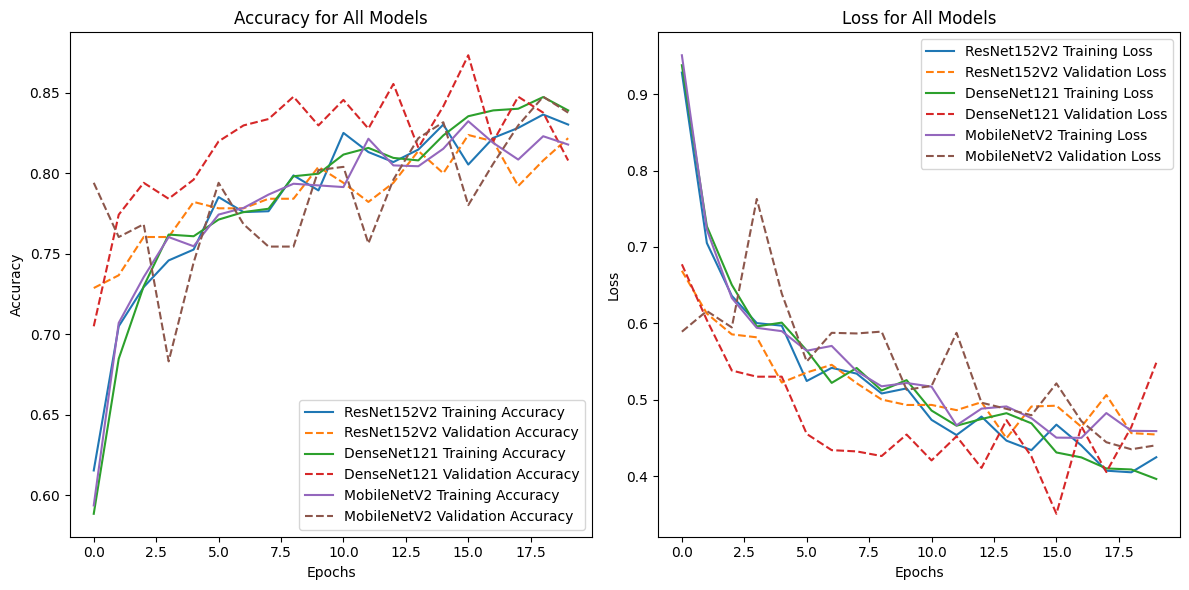

In [ ]:
# Menampilkan grafik akurasi dan loss untuk semua model
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
for model_name, hist in history_dict.items():
    plt.plot(hist['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(hist['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
for model_name, hist in history_dict.items():
    plt.plot(hist['loss'], label=f'{model_name} Training Loss')
    plt.plot(hist['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()